# ✨✨Asteroid Close Approach Analyzer✨✨

### Problem Motivation

     On average, about one 10m asteroid passes within lunar distance of the Earth each day. Some are too small to be detected before they pass, and a still larger portion are suspected to pass by whilst escaping detection altogether. Most people are unaware of these cosmic encounters, and those that do make the news are largely sensationalized, leading to public panic, or overly technical, causing a lack of accessibility. Thus, we wanted to create a system capable of monitoring real data on the positions and trajectories of asteroids, contextualizing risk in a readable manner, and distinguishing between routine passes and dangerous anomalies. 
     This project addresses these challenges by:
     - Automatically fetching and processing current asteroid approach data
     - Organizing temporal patterns to identify trends
     - Applying scientific criteria to assess actual risk levels
     - Generating clear, contextual explanations suitable for public consumption

### Setup and Dependencies  
    This cell begins importing the necessary packages and checks that Skyfield is installed. The `skyfield` library is used for accurate planetary position calculations in our 3D solar system visualization.

In [37]:
#CELL: Package Installation
import subprocess
import sys
#If you encounter any installation errors, you can manually install skyfield by running the following command in your terminal (not in this notebook): pip install skyfield.
def install_skyfield():
    """Install skyfield package if not already installed."""
    try:
        import skyfield
        print("Skyfield already installed.")
    except ImportError:
        print("Skyfield not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "skyfield"]) #automatically installs the skyfield package if it's not already present
        print("Skyfield installed successfully.")

install_skyfield() #Run this before your other imports

Skyfield already installed.


### Import Libraries

    This cell imports all the necessary libraries for data fetching, processing, and visualization.

In [38]:
#CELL: Import Required Libraries

#Data Fetching and API Communication 
import requests  #HTTP requests to NASA JPL API
from pathlib import Path  #Cross-platform file path handling
from requests.adapters import HTTPAdapter  #Connection pooling and retry logic
from urllib3.util.retry import Retry  #Automatic retry configuration

#Data Processing 
import pandas as pd  #DataFrame operations for tabular asteroid data
import numpy as np  #Numerical computations and array operations
import json  #JSON parsing for API responses
from datetime import datetime, timedelta  #Date/time manipulation for approach windows

#Visualization 
import matplotlib.pyplot as plt  #2D plotting and figure creation
from mpl_toolkits.mplot3d import Axes3D  #3D plotting for solar system visualization 

#User Interface (Loading Window) 
import tkinter as tk  #GUI toolkit for progress window
from tkinter import ttk  #Themed widgets (progress bar)

#Concurrency 
import threading  #Data fetching while showing progress
import time  #Sleep/delay functions for UI updates

### Configuration and Constants
    This cell defines API endpoints, file paths, and scientific thresholds used throughout the analysis.

In [39]:
#CELL: Script Configuration and Constants
#Output and Cache Settings
OUTPUT_DIR = Path("plots")  #Directory where visualization plots are saved
RETENTION_DAYS = 3  #Auto-deletes plots older than 3 days to save space

CACHE_DIR = Path("cache")  #Root cache directory for API responses
SBDB_CACHE_DIR = CACHE_DIR / "sbdb"  #Subdirectory for orbital element cache
SBDB_CACHE_TTL_DAYS = 30  #Orbital data expires after 30 days

#NASA JPL API Endpoints
API_URL = "https://ssd-api.jpl.nasa.gov/cad.api"  #Close Approach Data API
SBDB_URL = "https://ssd-api.jpl.nasa.gov/sbdb.api"  #Small-Body Database (orbital elements)

#Astronomical Constants
AU_TO_KM = 149597870.7  #1 Astronomical Unit (AU) = Earth-Sun distance in km
AU_TO_LD = 389.5  #1 AU ≈ 389.5 Lunar Distances 

#Potentially Hazardess Asteroid (PHA) Criteria:
#An asteroid is classified as "Potentially Hazardous" if
#   1. Absolute magnitude H ≤ 22.0 (diameter roughly ≥ 140 meters)
#   2. Minimum orbit intersection distance ≤ 0.05 AU (~7.5M km, ~19.5 LD)

PHA_H_THRESHOLD = 22.0  #Maximum H value for PHA classification (lower H = larger object)

#Visualization Thresholds:
#For non-hazardous asteroids, only show "relatively close" approaches
# Define "close" as within 10 Lunar Distances for display purposes

NON_HAZ_CLOSE_AU = 10.0 / AU_TO_LD  # Convert 10 LD to AU (~0.0257 AU)

### Helper Functions
    This cell includes utility functions for API communication, caching, file management, and coordinate transformations. Functions here create and manage the loading window that displays progress during data fetching. The loading window runs on the main thread while data fetching happens in a background thread. This prevents the GUI from freezing during the 10-30 second API query process.

In [40]:
#CELL: Helper Functions - GUI Components
#These functions create a progress window that displays during the lengthy API data fetching process

def create_loading_window():
    """
    Creates and returns a simple tkinter loading window with progress bar.
    
    The window displays:
    - Current operation status (e.g., "Fetching data 3/6...")
    - Progress bar showing completion percentage
    
    Returns:
        tuple: (root, status_label, progress_bar)
            - root: tk.Tk main window object
            - status_label: ttk.Label for status text updates
            - progress_bar: ttk.Progressbar widget (0-100 scale)
    """
    root = tk.Tk()
    root.title("Loading Asteroid Data")

    #Center window on screen
    window_width = 350
    window_height = 100
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    x_cordinate = int((screen_width/2) - (window_width/2))
    y_cordinate = int((screen_height/2) - (window_height/2))
    root.geometry(f"{window_width}x{window_height}+{x_cordinate}+{y_cordinate}")
    
    #Window properties
    root.resizable(False, False)  # Fixed size (no maximize/resize)
    root.attributes("-topmost", True)  # Keep window on top during loading
    
    #Create widgets
    frame = ttk.Frame(root, padding="20")
    frame.pack(expand=True, fill="both")
    
    #Status text label
    status_label = ttk.Label(frame, text="Initializing...", font=("Helvetica", 11))
    status_label.pack(pady=5)
    
    #Progress bar (0-100%)
    progress = ttk.Progressbar(frame, orient="horizontal", length=300, mode="determinate")
    progress.pack(pady=5)
    
    return root, status_label, progress

### Progress Update and Window Management Functions

    These utility functions handle critical elements for a good user experience, including keeping the loading window responsive during data fetching and ensuring plots display properly across different systems. The `update_progress()` function enables thread-safe GUI updates. Since the data pipeline runs in a background thread (to prevent UI freezing during the API fetch), we need a safe way to update the progress bar and status text from that thread. This function checks that widgets still exist before updating them, preventing crashes if the user closes the window early. Matplotlib can use different GUI backends (TkAgg, Qt, wxPython, etc.) depending on the user's system, and each has different methods for maximizing windows. This function attempts all common approaches in sequence, ensuring our large visualization opens maximized for optimal viewing, regardless of backend. If all methods fail, the window simply opens at default size—the function fails gracefully without breaking the program.

In [41]:
#CELL: Helper Functions - Progress Updates and Window Management
#The data fetching runs in a background thread, but tkinter GUI updates must happen on the main thread. These functions safely bridge that gap.

def update_progress(label, progress_bar, text, value):
    """
    Thread-safe way to update the loading window's status and progress bar.
    
    This function checks if widgets still exist before updating them,
    preventing errors if the window was closed during background operations.
    
    Args:
        label: ttk.Label widget to update with status text
        progress_bar: ttk.Progressbar widget to update
        text: str, new status message (e.g., "Fetching data (3/6)...")
        value: int/float, progress percentage (0-100)
    
    Example:
        update_progress(status_label, progress, "Processing data...", 75)
    """
    if label and label.winfo_exists():
        label.config(text=text)
    if progress_bar and progress_bar.winfo_exists():
        progress_bar['value'] = value

#Matplotlib window management
def maximize_figure_window(fig): #Automatically maximize the plot window for better viewing experience
    """
    Attempts to maximize the matplotlib plot window across different backends.
    
    Matplotlib uses different GUI backends depending on the system/installation.
    This function tries multiple approaches to maximize the window, falling
    back gracefully if a particular backend method isn't available.
    
    Args:
        fig: matplotlib.figure.Figure object to maximize
    
    Note:
        - TkAgg backend (most common): Uses window.state('zoomed')
        - Qt backend: Uses window.showMaximized()
        - wx backend: Uses frame.Maximize(True)
        - If all fail, window opens at default size (still functional)
    """
    try:
        manager = plt.get_current_fig_manager()
        
        #Attempt 1: TkAgg backend (Windows/default)
        if hasattr(manager, 'window') and hasattr(manager.window, 'state'):
            try:
                manager.window.state('zoomed')
                return
            except Exception:
                pass
        
        #Attempt 2: Qt backend (PyQt5/PySide2)
        if hasattr(manager, 'window') and hasattr(manager.window, 'showMaximized'):
            try:
                manager.window.showMaximized()
                return
            except Exception:
                pass
        
        #Attempt 3: wx backend (wxPython)
        if hasattr(manager, 'frame') and hasattr(manager.frame, 'Maximize'):
            try:
                manager.frame.Maximize(True)
                return
            except Exception:
                pass
                
    except Exception:
        #If the user has none of these, the window will open at a default size
        pass

### Network, File Management, and Caching Functions

    These functions handle robust API communication and efficient data management. The `create_session_with_retries()` function creates an HTTP session that automatically retries failed requests. This is critical for the NASA API, which can experience intermittent network issues. The file management functions prevent disk bloat and caches orbital data by removing old visualizations to avoid redundant API calls. Orbital elements rarely change, so caching them every 30 days dramatically reduces API load when re-running analyses.

In [42]:
#CELL: Helper Functions - Network, Caching, and File Management

def create_session_with_retries(total_retries=3, backoff_factor=0.5, #robust http session with automatic retries
                                status_forcelist=(429, 500, 502, 503, 504)):
    """
    Creates a requests.Session with automatic retries for failed HTTP requests.
    
    Retry behavior:
    - Retries on connection errors, timeouts, and specific HTTP status codes
    - Uses exponential backoff: waits 0.5s, 1s, 2s between retries
    - Retries on 429 (rate limit), 500+ (server errors)
    
    Args:
        total_retries: Maximum number of retry attempts (default: 3)
        backoff_factor: Delay multiplier between retries (default: 0.5)
        status_forcelist: HTTP status codes that trigger retries
    
    Returns:
        requests.Session: Configured session with retry logic
    """
    session = requests.Session()
    retry = Retry(
        total=total_retries,
        read=total_retries,
        connect=total_retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,  #Retry on these HTTP codes
        allowed_methods=("GET", "POST"),  #Only retry safe methods
        raise_on_status=False,  #Don't raise exceptions automatically
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount("http://", adapter)  #Apply to HTTP
    session.mount("https://", adapter)  #Apply to HTTPS
    return session

#File cleanup and automatic deletion of old plots

def cleanup_old_files(directory: Path, days: int) -> None: #Prevents the plots/ directory from filling up with old visualizations
    """
    Removes PNG files older than the specified number of days.
    
    This prevents the output directory from accumulating hundreds of old
    plot files over time. Only deletes .png files (preserves other formats).
    
    Args:
        directory: Path to directory to clean
        days: Delete files older than this many days
    """
    if not directory.exists():
        return
    
    cutoff = pd.Timestamp.now(tz=None) - pd.Timedelta(days=days)
    
    for p in directory.glob("*.png"):
        try:
            mtime = pd.Timestamp(p.stat().st_mtime, unit='s')
            if mtime < cutoff:
                p.unlink(missing_ok=True)
        except Exception:
            pass  #Skip files we can't delete (permission errors and the such)

#JSON cache management and orbital elements
def load_json_cache(cache_path: Path, max_age_days: int):
    """
    Load cached JSON data if it exists and isn't too old.
    
    Args:
        cache_path: Path to cached JSON file
        max_age_days: Maximum cache age before considered stale
    
    Returns:
        dict or None: Cached data if valid, None if missing/expired/corrupted
    """
    try:
        if not cache_path.exists():
            return None
        
        #Check cache age
        age_days = (pd.Timestamp.now(tz=None) - 
                   pd.Timestamp(cache_path.stat().st_mtime, unit='s')).days
        if age_days > max_age_days:
            return None  #Cache expired
        
        #Load and return cached data
        with cache_path.open('r', encoding='utf-8') as f:
            return json.load(f)
    except Exception:
        return None  #corrupted cache or read error

def save_json_cache(cache_path: Path, data: dict):
    """
    Save data to JSON cache file.
    
    Args:
        cache_path: Path where cache should be saved
        data: Dictionary to cache (must be JSON-serializable)
    """
    try:
        cache_path.parent.mkdir(parents=True, exist_ok=True)  # Create cache dir
        with cache_path.open('w', encoding='utf-8') as f:
            json.dump(data, f)
    except Exception:
        pass  #Fail silently without crashing the code or causing a fuss

### Data Pipeline - Fetching and Processing Asteroid Data

    This cell is the core data processing function that runs in a background thread while the loading window displays progress. It performs four main stages: 
    
    1. fetching 6-month windows of asteroid data from NASA's API in batches
    2. cleaning and parsing the raw JSON into structured DataFrames
    3. calculating derived metrics and applying PHA classification criteria
    4. filtering into time-window subsets for visualization. 
    
    The function updates the progress bar at each stage and stores results in global variables accessible to the plotting functions. The API has URL length limits and performs better with smaller date ranges. We split the 6-month window into six 15-30 day chunks, fetched them sequentially, then concatenated them. This also enables granular progress reporting so users know the system hasn't frozen.

In [43]:
#CELL: Data Pipeline and Main Processing Function
#This function runs in a separate thread to avoid freezing the API. It fetches ~1500-2000 asteroid records, processes them, and stores results in global variables for the plotting functions to use.

def run_data_pipeline(status_label, progress_bar, on_complete_callback):
    """
    Main function to fetch and process asteroid close approach data.
    Designed to run in a worker thread to keep GUI responsive.
    
    Processing stages:
    1. Fetch data from NASA API in 6 batches (15-30 day windows each)
    2. Parse and clean JSON responses into Pandas DataFrames
    3. Calculate derived metrics (distances in km/LD, PHA classification)
    4. Filter into time-window subsets (7 days, 30 days, 6 months)
    
    Args:
        status_label: GUI label widget for status text updates
        progress_bar: GUI progress bar widget (0-100 scale)
        on_complete_callback: Function to call when pipeline finishes
    
    Side Effects:
        - Updates global variables: df_non_hazardous_close, df_haz_7_days, 
          df_haz_30_days, df_haz_6_months
        - Updates global pipeline_results tuple
        - Creates ~1-3 second pause at 100% so user can see completion
    """
    
    #Declare globals (so we can call these later outside of this function)
    global df_non_hazardous_close, df_haz_7_days, df_haz_30_days, df_haz_6_months
    global pipeline_results  # Tuple of all four dataframes
    
    try:
        #PART A: data fetching
        #Split 6 month query into 6 chunks for better API performance and granular progress reporting. Each request fetches ~200-400 records.

        api_configs = [
            {'date-min': 'now', 'date-max': '+15', 'dist-max': '0.5'},    # Next 15 days
            {'date-min': '+16', 'date-max': '+30', 'dist-max': '0.5'},    # Days 16-30
            {'date-min': '+31', 'date-max': '+45', 'dist-max': '0.5'},    # Days 31-45
            {'date-min': '+46', 'date-max': '+60', 'dist-max': '0.5'},    # Days 46-60
            {'date-min': '+61', 'date-max': '+120', 'dist-max': '0.5'},   # Days 61-120
            {'date-min': '+121', 'date-max': '+180', 'dist-max': '0.5'}   # Days 121-180
        ]
        
        all_dataframes = []
        session = create_session_with_retries()  #HTTP session with auto-retry
        
        for i, config in enumerate(api_configs):
            #Update progress window
            status_text = f"Fetching data ({i+1}/6): {config['date-min']} to {config['date-max']}..."
            progress_value = 10 + (i * 10)  #Progress as a percentage
            update_progress(status_label, progress_bar, status_text, progress_value)

            #Build API request parameters
            params = {
                **config,  #Include date-min, date-max, dist-max
                'sort': 'dist',  #Sort by distance (closest first)
                'limit': '10000',  #Max results per request
                'diameter': 'true'  #Include diameter estimates
            }
            
            #Make API request with 30s timeout
            response = session.get(API_URL, params=params, timeout=30)
            response.raise_for_status()  #Raise exception if HTTP error
            
            #Parse JSON response
            data = response.json()
            if 'data' in data and data['data']:
                fields = data['fields']  #Column names
                all_dataframes.append(pd.DataFrame(data['data'], columns=fields))

        #Check if we got any data
        if not all_dataframes:
            update_progress(status_label, progress_bar, "No data returned from API. Exiting.", 100)
            on_complete_callback()
            return
        
        #Combine all 6 batches into single DataFrame
        df = pd.concat(all_dataframes, ignore_index=True)
        print(f"Successfully fetched {len(df)} total close approaches.")

        #PART B: data parsing and cleaning
        #Convert string columns to numeric types and parse dates
        
        update_progress(status_label, progress_bar, "Cleaning and parsing data...", 70)

        #Convert numeric columns from strings to floats
        cols_to_convert = ['dist', 'dist_min', 'dist_max', 'v_rel', 'h', 'diameter']
        for col in cols_to_convert:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')  #Invalid → NaN
        
        #Parse close approach dates
        df['cd_datetime'] = pd.to_datetime(df['cd'])
        
        #Remove rows with missing critical data
        df = df.dropna(subset=['dist', 'h', 'cd_datetime'])

        #PART C: data analysis and classification
        #Calculate derived metrics and apply PHA criteria
        
        update_progress(status_label, progress_bar, "Analyzing and filtering...", 90)

        #Calculate distances in multiple units
        df['dist_km'] = df['dist'] * AU_TO_KM  #Kilometers
        df['dist_lunar'] = df['dist'] * AU_TO_LD  #Lunar distances
        
        #Apply PHA classification criteria
        #PHA = distance ≤ 0.05 AU AND absolute magnitude ≤ 22 (size ≥ 140m)
        df['is_hazardous'] = ((df['dist'] <= 0.05) & (df['h'] <= PHA_H_THRESHOLD))

        #Define time windows for filtering
        now = datetime.now()
        plus_7_days = now + timedelta(days=7)
        plus_30_days = now + timedelta(days=30)
        plus_60_days = now + timedelta(days=60)
        plus_6_months = now + timedelta(days=180)

        #Filter 1: Non-hazardous, relatively close (next 60 days)
        #Show non-PHAs that are still close enough to be interesting
        df_non_hazardous_close = df[
            (df['cd_datetime'] <= plus_60_days) & 
            (df['dist'] <= NON_HAZ_CLOSE_AU) &  #Within 10 lunar distances
            (df['is_hazardous'] == False)
        ].copy()

        #Filter 2: Potentially hazardous (next 7 days)
        #Most imminent PHAs - top 25 by distance
        df_haz_7_days = df[
            (df['cd_datetime'] <= plus_7_days) & 
            (df['is_hazardous'] == True)
        ].sort_values(by='dist_lunar').head(25)

        #Filter 3: Potentially hazardous (8-30 days)
        #Near-term PHAs - top 25 by distance
        df_haz_30_days = df[
            (df['cd_datetime'] > plus_7_days) & 
            (df['cd_datetime'] <= plus_30_days) & 
            (df['is_hazardous'] == True)
        ].sort_values(by='dist_lunar').head(25)

        #Filter 4: Potentially hazardous (31-180 days)
        #Medium-term PHAs - top 25 by distance
        df_haz_6_months = df[
            (df['cd_datetime'] > plus_30_days) & 
            (df['cd_datetime'] <= plus_6_months) & 
            (df['is_hazardous'] == True)
        ].sort_values(by='dist_lunar').head(25)

        #PART D: storing results
        #Save filtered dataframes to global variables for plotting
        
        pipeline_results = (df_non_hazardous_close, df_haz_7_days, df_haz_30_days, df_haz_6_months)
        update_progress(status_label, progress_bar, "Data processed. Finishing up...", 100)
        
    except Exception as e:
        print(f"An error occurred in the data pipeline: {e}")
        update_progress(status_label, progress_bar, f"Error: {e}", 100)
    finally:
        time.sleep(0.5)  #Brief pause so user can see 100% completion
        on_complete_callback()  #Close loading window

### Verify Data Pipeline Results

    Before proceeding to visualization, it's important to verify that the data pipeline successfully created and populated all four filtered dataframes. This cell checks for the existence of the global variables and displays how many asteroid records are in each category.

In [44]:
#Check if the global variables were created
try:
    print(f"✓ df_non_hazardous_close: {len(df_non_hazardous_close)} rows") #If this shows up, you know the variables have been created. This prevents later cells from returning errors if the variables aren't found.
    print(f"✓ df_haz_7_days: {len(df_haz_7_days)} rows")
    print(f"✓ df_haz_30_days: {len(df_haz_30_days)} rows")
    print(f"✓ df_haz_6_months: {len(df_haz_6_months)} rows")
except NameError as e:
    print(f"✗ Variable not found: {e}")
    print("You need to run the cell that calls run_data_pipeline() first!") #Common troubleshoot suggestion

✓ df_non_hazardous_close: 10 rows
✓ df_haz_7_days: 0 rows
✓ df_haz_30_days: 4 rows
✓ df_haz_6_months: 2 rows


### Astronomical Calculation Functions

    These functions perform the mathematical transformations needed to visualize asteroid and planet orbits in 3D space. They convert Keplerian orbital elements into Cartesian coordinates (x, y, z positions in space) so they can be plotted. This is complex because orbits are naturally described using 6 parameters (semi-major axis, eccentricity, inclination, etc.), but to draw them on a 3D plot, we need Cartesian coordinates. This requires solving Kepler's equation, a transcendental equation with no closed-form solution, and applying 3D rotation matrices to transform from the orbital plane to the ecliptic reference frame. These functions implement the classical orbital mechanics algorithms used throughout astronomy and spaceflight. In this case, AI was particularly useful in producing the necessary matrices and equations to code this process.

In [45]:
#CELL: Astronomical Calculations - Orbital Mechanics

def kepler_solve_eccentric_anomaly(mean_anomaly_rad, eccentricity, tol=1e-10, max_iter=50): #Solving Kepler's Equation
    """
    Solve Kepler's equation M = E - e*sin(E) for eccentric anomaly E.
    
    Uses Newton-Raphson iteration:
    E_new = E_old - f(E)/f'(E)
    where f(E) = E - e*sin(E) - M
    
    Args:
        mean_anomaly_rad: Mean anomaly in radians (0 to 2π)
        eccentricity: Orbital eccentricity (0 = circle, <1 = ellipse)
        tol: Convergence tolerance (default: 1e-10 radians)
        max_iter: Maximum iterations (default: 50)
    
    Returns:
        float: Eccentric anomaly E in radians
    
    Note:
        Initial guess depends on eccentricity:
        - Low eccentricity (e < 0.8): Start with E ≈ M (good approximation)
        - High eccentricity (e ≥ 0.8): Start with E = π (safer choice)
    """
    M = np.mod(mean_anomaly_rad, 2 * np.pi)  #Normalize to [0, 2π] domain
    
    #Initial guess based on eccentricity
    if eccentricity < 0.8:
        E = M  #For nearly circular orbits, E ≈ M
    else:
        E = np.pi  #For eccentric orbits, use safer starting point
    
    for _ in range(max_iter): #Newton-Raphson iteration
        f = E - eccentricity * np.sin(E) - M  #Function value
        f_prime = 1 - eccentricity * np.cos(E)  #Derivative
        delta = -f / f_prime  #Newton step
        E = E + delta
        
        #Check convergence
        if np.all(np.abs(delta) < tol):
            break
    
    return E
#Orbital elements to Cartesian position
def orbital_elements_to_position_au(a_au, e, i_deg, omega_deg, w_deg, M_deg): #Converts the 6 Keplerian orbital elements into 3D position (x, y, z) in the heliocentric ecliptic reference frame (Sun at origin)
    """
    Convert Keplerian orbital elements to heliocentric ecliptic position.
    
    Orbital elements:
        a_au: Semi-major axis in AU (orbit size)
        e: Eccentricity (orbit shape: 0=circle, <1=ellipse)
        i_deg: Inclination in degrees (tilt relative to ecliptic plane)
        omega_deg: Longitude of ascending node (Ω) in degrees
        w_deg: Argument of periapsis (ω) in degrees
        M_deg: Mean anomaly in degrees (position along orbit vs time)
    
    Returns:
        tuple: (x, y, z) position in AU in ecliptic reference frame
    
    Process:
        1. Solve Kepler's equation for eccentric anomaly E
        2. Calculate true anomaly ν (actual angle from periapsis)
        3. Calculate distance r from focus (Sun)
        4. Get position in orbital plane coordinates
        5. Rotate to ecliptic frame using 3D rotation matrices
    """
    #Step 1: Convert angles to radians
    i = np.deg2rad(i_deg)
    Omega = np.deg2rad(omega_deg)  #Longitude of ascending node
    w = np.deg2rad(w_deg)  #Argument of periapsis
    M = np.deg2rad(M_deg)  #Mean anomaly
    E = kepler_solve_eccentric_anomaly(M, e)  #Step 2: Solve Kepler's equation for eccentric anomaly
    #Step 3: Calculate true anomaly (actual angular position)
    nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2), #True anomaly formula: tan(ν/2) = sqrt((1+e)/(1-e)) * tan(E/2)
                        np.sqrt(1 - e) * np.cos(E / 2))
    #Step 4: Calculate distance from Sun (focal point)
    r = a_au * (1 - e * np.cos(E))  #Distance in AU
    #Step 5: Position in orbital plane coordinates
    x_orb = r * np.cos(nu)  #Along periapsis direction
    y_orb = r * np.sin(nu)  #Perpendicular in orbital plane
    z_orb = 0.0  #Orbital plane is flat
    cO, sO = np.cos(Omega), np.sin(Omega) #Step 6: Rotate from orbital plane to ecliptic frame
    ci, si = np.cos(i), np.sin(i) #Rotation sequence: R = Rz(Ω) * Rx(i) * Rz(ω)
    cw, sw = np.cos(w), np.sin(w) #Pre-calculate trig functions for rotation matrices
    R11 = cO * cw - sO * sw * ci #Combined rotation matrix elements
    R12 = -cO * sw - sO * cw * ci
    R13 = sO * si
    
    R21 = sO * cw + cO * sw * ci
    R22 = -sO * sw + cO * cw * ci
    R23 = -cO * si
    
    R31 = sw * si
    R32 = cw * si
    R33 = ci
    
    #Apply rotation: [x, y, z] = R * [x_orb, y_orb, z_orb]
    x = R11 * x_orb + R12 * y_orb + R13 * z_orb
    y = R21 * x_orb + R22 * y_orb + R23 * z_orb
    z = R31 * x_orb + R32 * y_orb + R33 * z_orb
    
    return float(x), float(y), float(z)

### Planet and Asteroid Orbital Data

    These functions retrieve orbital elements from NASA's Small-Body Database and provide fixed, immutable data for the inner planets. The `try_fetch_sbdb_elements()` function queries the SBDB API for a specific asteroid's orbital parameters and caches them locally to avoid redundant requests, since orbital elements change slowly. The `build_planet_catalog()` provides accurate orbital data for Mercury through Mars used in the 3D solar system visualization.

In [46]:
def try_fetch_sbdb_elements(designation): 
    """Fetch orbital elements from SBDB; returns dict with a,e,i,om,w,ma (deg)."""
    try:
        #Check local JSON cache before making API request
        safe_des = str(designation).replace('/', '_').replace(' ', '_')
        cache_file = SBDB_CACHE_DIR / f"{safe_des}.json"
        cached = load_json_cache(cache_file, SBDB_CACHE_TTL_DAYS)
        if cached and isinstance(cached, dict):
            return cached
        
        #Query NASA JPL SBDB API for orbital elements
        resp = requests.get(SBDB_URL, params={"des": designation}, timeout=15)
        resp.raise_for_status()
        j = resp.json()
        
        #Extract Keplerian elements from nested JSON structure
        orbit = j.get("orbit") or {}
        elements = orbit.get("elements") or {}
        a = float(elements.get("a", {}).get("value"))      #semi-major axis (AU)
        e = float(elements.get("e", {}).get("value"))      #eccentricity
        i = float(elements.get("i", {}).get("value"))      #inclination (deg)
        om = float(elements.get("om", {}).get("value"))    #longitude of ascending node (deg)
        w = float(elements.get("w", {}).get("value"))      #argument of perihelion (deg)
        ma = float(elements.get("ma", {}).get("value"))    #mean anomaly (deg)
        n = elements.get("n", {})
        n = float(n.get("value")) if n else None           #mean motion (deg/day)
        epoch = elements.get("epoch", {})
        epoch = float(epoch.get("value")) if epoch else None  #epoch (JD TDB)
        
        #Cache result and return
        result = {"a": a, "e": e, "i": i, "om": om, "w": w, "ma": ma, "n": n, "epoch": epoch}
        save_json_cache(cache_file, result)
        return result
    except Exception:
        return None  #Graceful failure; caller handles missing data

def build_planet_catalog():
    """Return simple planet data up to Mars with semi-major axis and radii (km)."""
    #Hardcoded orbital elements and physical radii for inner planets
    return [
        {"name": "Mercury", "a": 0.387098, "e": 0.205630, "i": 7.0049, "om": 48.331, "w": 29.124, "ma": 174.796, "radius_km": 2439.7},
        {"name": "Venus",   "a": 0.723332, "e": 0.006772, "i": 3.3947, "om": 76.680, "w": 54.884, "ma": 50.115,  "radius_km": 6051.8},
        {"name": "Earth",   "a": 1.000000, "e": 0.016710, "i": 0.0000, "om": -11.260, "w": 114.207, "ma": 358.617, "radius_km": 6371.0},
        {"name": "Mars",    "a": 1.523679, "e": 0.093400, "i": 1.850,  "om": 49.558, "w": 286.502, "ma": 19.373,  "radius_km": 3389.5},
    ]

def log_scale_sizes(radii_km, min_size=20, max_size=80):
    """Apply log scaling to radii for proportional visualization across orders of magnitude."""
    r = np.array(radii_km, dtype=float)
    r = np.maximum(r, 1.0)
    logr = np.log10(r)
    logr = (logr - logr.min()) / (logr.max() - logr.min() + 1e-9)
    return min_size + logr * (max_size - min_size)

def julian_date_utc(now_dt=None):
    """Convert UTC datetime to Julian Date using standard astronomical formula."""
    now = now_dt or datetime.utcnow()
    year = now.year
    month = now.month
    day = now.day + (now.hour + (now.minute + now.second/60.0)/60.0)/24.0
    #Standard JD calculation with Gregorian calendar correction
    if month <= 2:
        year -= 1
        month += 12
    A = int(year/100)
    B = 2 - A + int(A/4)
    jd = int(365.25*(year + 4716)) + int(30.6001*(month + 1)) + day + B - 1524.5
    return jd

_skyfield_cache = {"loaded": False, "eph": None, "ts": None, "ecliptic": None} #Global cache for Skyfield ephemeris objects (avoids repeated file loading)

### Skyfield Integration & 3D Visualization

    This cell implements the interactive 3D solar system visualization and precise planet position calculations. The `init_skyfield_if_available()` function dynamically imports the Skyfield library and loads the DE421 ephemeris for accurate planetary positions. The `get_planet_positions_au_with_skyfield()` function queries real-time heliocentric positions in ecliptic coordinates, providing significantly more accurate planet locations than simplified Keplerian elements.
    The `create_and_show_plot()` function orchestrates the entire visualization dashboard using a complex matplotlib GridSpec layout: a left text panel for documentation and four right panels for scatter plots and the 3D solar system map. The 3D view includes planet orbits represented by yellow curves, current positions with directional arrows, and a subtle asteroid belt band. An interactive click handler allows users to select any asteroid point from the other graphs, dynamically overlaying its full orbital trajectory in red with directional arrows on the 3D map. This provides an intuitive way to explore how specific asteroids relate spatially to the inner solar system.

Showing loading window...
Successfully fetched 1715 total close approaches.
Loading window closed.
Generating plot...
Saving plot and cleaning up...
Saved plot to plots\asteroid_close_approaches_20251103_105211.png
Showing plot...


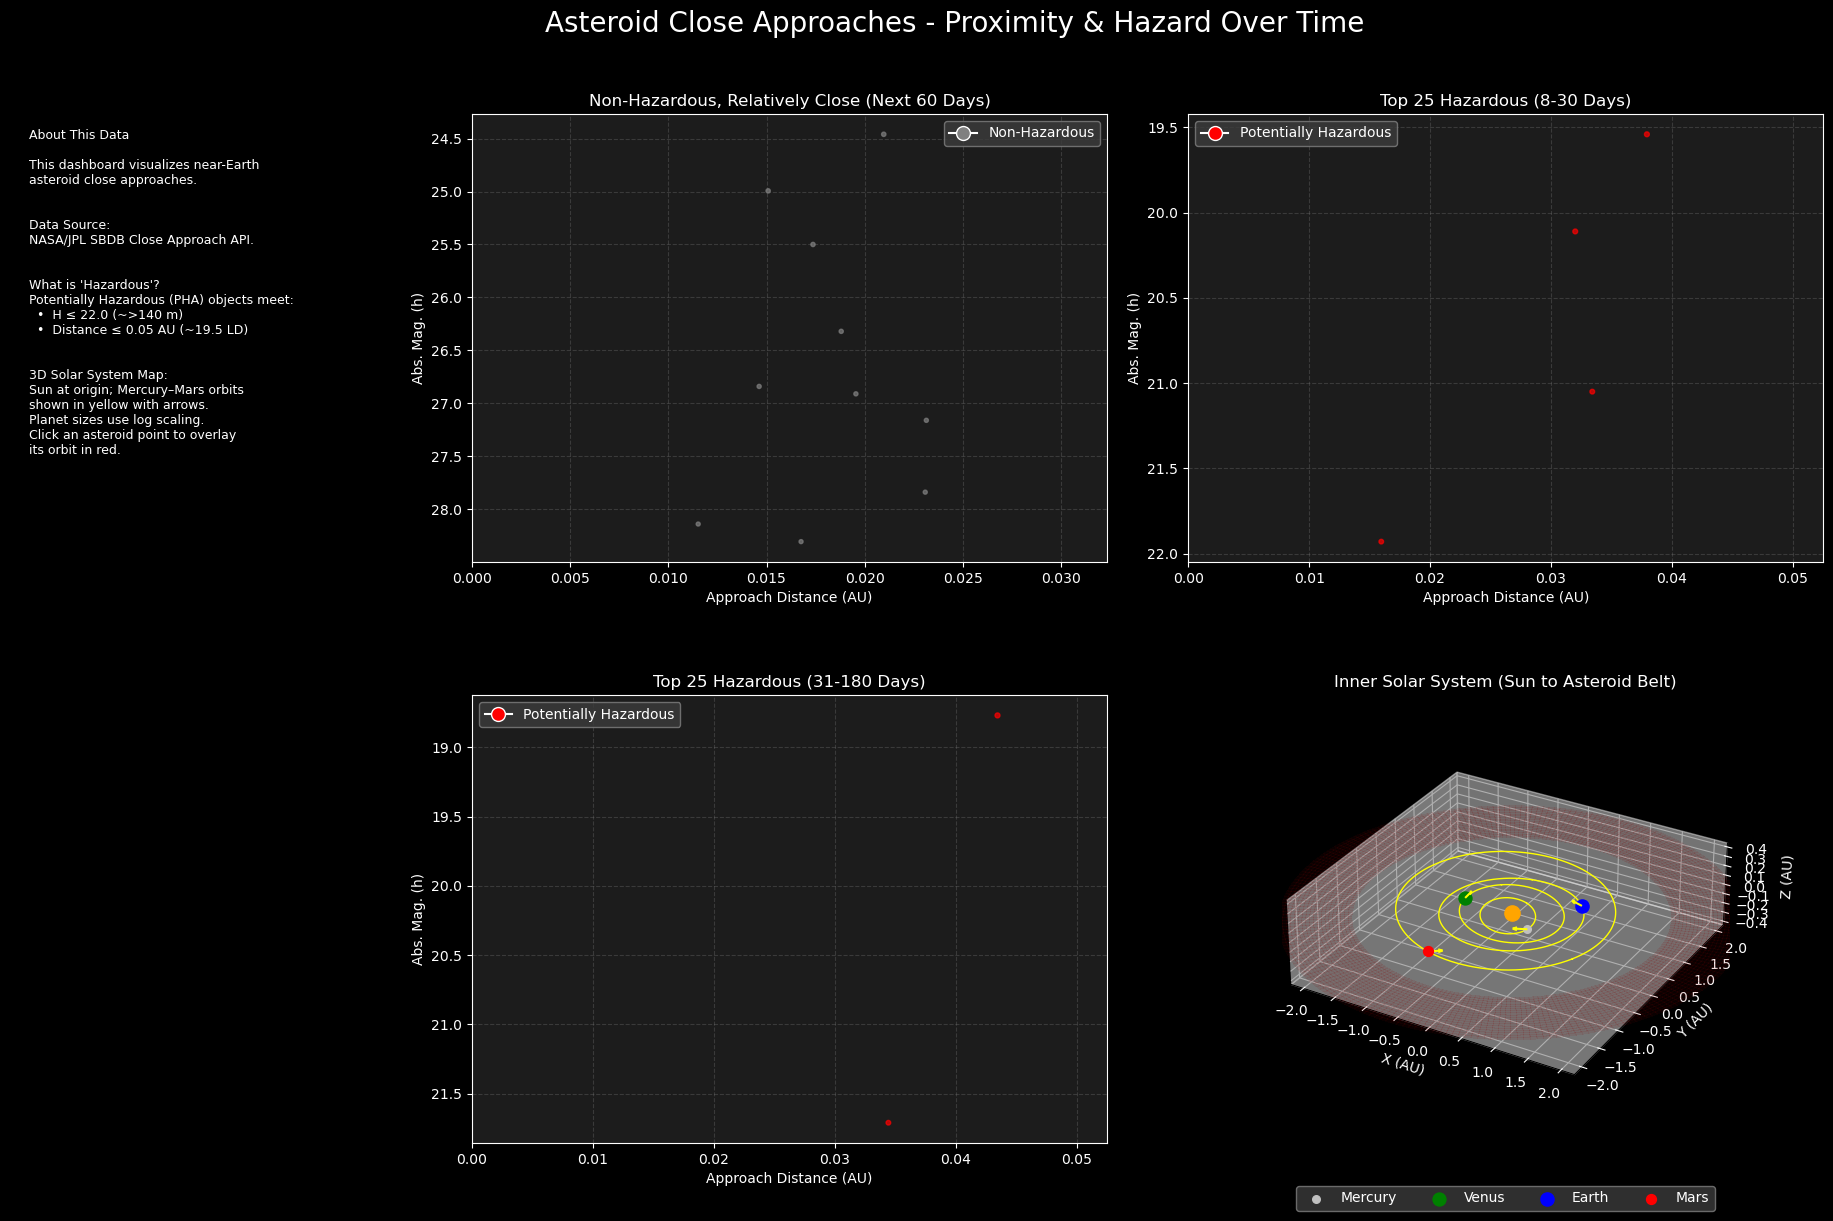

In [47]:
def init_skyfield_if_available():
    """Initialize Skyfield ephemeris and timescale objects with caching."""
    if _skyfield_cache["loaded"]:
        return True
    #Dynamic import to avoid static linting errors when Skyfield not installed
    import importlib
    _api = importlib.import_module('skyfield.api')
    _fr = importlib.import_module('skyfield.framelib')
    load = _api.load
    _ecliptic_frame = _fr.ecliptic_frame
    
    #Load JPL DE421 ephemeris (covers years 1900-2050) and timescale
    ts = load.timescale()
    eph = load("de421.bsp")
    _skyfield_cache.update({"loaded": True, "eph": eph, "ts": ts, "ecliptic": _ecliptic_frame})
    return True

def get_planet_positions_au_with_skyfield():
    """Return dict of planet name -> (x,y,z) AU in ecliptic frame, if available."""
    if not init_skyfield_if_available():
        return None
    eph = _skyfield_cache["eph"]
    ts = _skyfield_cache["ts"]
    t = ts.now()  #Current time
    sun = eph['sun']
    
    #Query barycenter positions for inner planets
    bodies = {
        "Mercury": eph['mercury barycenter'],
        "Venus": eph['venus barycenter'],
        "Earth": eph['earth barycenter'],
        "Mars": eph['mars barycenter'],
    }
    
    result = {}
    for name, body in bodies.items():
        #Get heliocentric position in ecliptic frame
        vec = (body - sun).at(t).frame_latlon(_skyfield_cache["ecliptic"])
        lat, lon, distance = vec  #Spherical coordinates
        r = distance.au
        latr = lat.radians
        lonr = lon.radians
        
        #Convert from ecliptic spherical to Cartesian coordinates
        x = r * np.cos(latr) * np.cos(lonr)
        y = r * np.cos(latr) * np.sin(lonr)
        z = r * np.sin(latr)
        result[name] = (x, y, z)
    return result
    
#3B. plotting function (this runs on the main thread) 
def create_and_show_plot(df_non_hazardous_close, df_haz_7_days, df_haz_30_days, df_haz_6_months):
    """
    Creates, saves, and shows the matplotlib plot.
    This function MUST run on the main thread.
    """
    print("Generating plot...")
    
    #Configure figure with GridSpec: left text panel (narrow) + 2x2 plot grid (right)
    fig = plt.figure(figsize=(19.2, 12.8))
    fig.patch.set_facecolor('black')
    gs = fig.add_gridspec(2, 3, width_ratios=[0.6, 1.0, 1.0])

    #Left panel: informational text (spans both rows)
    ax_text = fig.add_subplot(gs[:, 0])
    ax_text.set_facecolor('black')
    ax_text.axis('off')

    info_text = ( #Define dashboard documentation text
        "About This Data\n\n"
        "This dashboard visualizes near-Earth\n"
        "asteroid close approaches.\n\n\n"
        "Data Source:\n"
        "NASA/JPL SBDB Close Approach API.\n\n\n"
        "What is 'Hazardous'?\n"
        "Potentially Hazardous (PHA) objects meet:\n"
        "  •  H ≤ 22.0 (~>140 m)\n"
        "  •  Distance ≤ 0.05 AU (~19.5 LD)\n\n\n"
        "3D Solar System Map:\n"
        "Sun at origin; Mercury–Mars orbits\n"
        "shown in yellow with arrows.\n"
        "Planet sizes use log scaling.\n"
        "Click an asteroid point to overlay\n"
        "its orbit in red."
    )

    ax_text.text(0.05, 0.985, info_text,
                 transform=ax_text.transAxes,
                 fontsize=9,
                 color='white',
                 va='top',
                 ha='left',
                 wrap=True)
    
    fig.suptitle('Asteroid Close Approaches - Proximity & Hazard Over Time', fontsize=20, color='white', y=0.98)

    #Right panel: create 4 subplot axes (3 scatter plots + 1 3D solar system)
    axes_list = [
        fig.add_subplot(gs[0, 1]),            #Top-left: Non-hazardous scatter
        fig.add_subplot(gs[0, 2]),            #Top-right: 8-30 day hazardous
        fig.add_subplot(gs[1, 1]),            #Bottom-left: 31-180 day hazardous
        fig.add_subplot(gs[1, 2], projection='3d')  #Bottom-right: 3D map
    ]
    
    #Map data frames to their respective plots with metadata
    plot_data_frames = [
        (df_non_hazardous_close, "Non-Hazardous, Relatively Close (Next 60 Days)", {'is_hazardous': False}),
        (df_haz_30_days, "Top 25 Hazardous (8-30 Days)", {'is_hazardous': True}),
        (df_haz_6_months, "Top 25 Hazardous (31-180 Days)", {'is_hazardous': True})
    ]

    #Compute uniform x-axis limit for hazardous plots
    max_dist_30 = df_haz_30_days['dist'].max() if not df_haz_30_days.empty else 0
    max_dist_180 = df_haz_6_months['dist'].max() if not df_haz_6_months.empty else 0
    uniform_xlim_max = max(max_dist_30, max_dist_180, 0.05)
    
    #Graph 4: 3D Solar System Map 
    ax3d = axes_list[3]
    ax3d.set_facecolor('#000000')
    ax3d.set_title('Inner Solar System (Sun to Asteroid Belt)', fontsize=12, color='white')
    
    #Style 3D axes with white labels and ticks
    for axis in [ax3d.xaxis, ax3d.yaxis, ax3d.zaxis]:
        axis.label.set_color('white')
        axis.set_tick_params(colors='white')
    for spine in getattr(ax3d, 'spines', {}).values():
        spine.set_edgecolor('white')

    #Sun at origin (orange sphere)
    ax3d.scatter([0], [0], [0], color='orange', s=120, marker='o')

    #Load planet data and compute log-scaled visual sizes
    planets = build_planet_catalog()
    sizes = log_scale_sizes([p['radius_km'] for p in planets], min_size=30, max_size=90)
    planet_colors = {"Mercury": 'silver', "Venus": 'green', "Earth": 'blue', "Mars": 'red'}

    #Draw asteroid belt as subtle red transparent surface (2.2–3.2 AU)
    try:
        r_inner, r_outer = 2.2, 3.2
        theta_b = np.linspace(0, 2*np.pi, 240)
        r_b = np.linspace(r_inner, r_outer, 20)
        Theta_b, R_b = np.meshgrid(theta_b, r_b)
        X_b = R_b * np.cos(Theta_b)
        Y_b = R_b * np.sin(Theta_b)
        Z_b = np.zeros_like(X_b)  #Flat on ecliptic plane
        ax3d.plot_surface(X_b, Y_b, Z_b, rstride=1, cstride=1, color='red', alpha=0.08, linewidth=0, antialiased=False)
    except Exception:
        pass

    #Draw planet orbits (yellow curves) and current positions with motion arrows
    max_range = 2.2  #Initial axis range (AU)
    theta = np.linspace(0, 2*np.pi, 800)
    sf_positions = get_planet_positions_au_with_skyfield()  #Accurate current positions
    
    for p, s in zip(planets, sizes):
        #Generate orbit curve from Keplerian elements
        Ms = np.rad2deg(theta)
        xs, ys, zs = [], [], []
        for Mdeg in Ms:
            x, y, z = orbital_elements_to_position_au(p['a'], p['e'], p['i'], p['om'], p['w'], Mdeg)
            xs.append(x); ys.append(y); zs.append(z)
        ax3d.plot(xs, ys, zs, color='yellow', lw=1.0)

        #Plot current position: Skyfield if available, else Keplerian approximation
        if sf_positions and p['name'] in sf_positions:
            x0, y0, z0 = sf_positions[p['name']]
        else:
            x0, y0, z0 = orbital_elements_to_position_au(p['a'], p['e'], p['i'], p['om'], p['w'], p['ma'])
        ax3d.scatter([x0], [y0], [z0], color=planet_colors.get(p['name'], 'white'), s=s, label=p['name'])
        
        #Add direction arrow showing orbital motion (yellow, tangent to orbit)
        x1, y1, z1 = orbital_elements_to_position_au(p['a'], p['e'], p['i'], p['om'], p['w'], p['ma'] + 1.0)
        ax3d.quiver(x0, y0, z0, x1 - x0, y1 - y0, z1 - z0, color='yellow', length=0.2, normalize=True)

    #Configure 3D axis limits and labels
    ax3d.set_xlabel('X (AU)')
    ax3d.set_ylabel('Y (AU)')
    ax3d.set_zlabel('Z (AU)')
    ax3d.set_xlim(-max_range, max_range)
    ax3d.set_ylim(-max_range, max_range)
    ax3d.set_zlim(-max_range/5, max_range/5)  #Compressed z-axis for better visibility
    try:
        ax3d.set_box_aspect((1, 1, 0.3))  #Aspect ratio favoring xy-plane
    except Exception:
        pass

    #Position legend below plot (horizontal layout)
    leg3d = ax3d.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=4)
    for text in leg3d.get_texts():
        text.set_color('white')
    leg3d.get_frame().set_facecolor('#3C3C3C')
    leg3d.get_frame().set_edgecolor('gray')

    #Storage for dynamically-drawn selected asteroid orbit
    selected_orbit_line = {"line": None, "arrows": []}

    def on_pick(event):
        """Handle click events on scatter plot points to overlay asteroid orbits."""
        artist = event.artist
        for axp, scp, dfp in point_metadata:
            if artist == scp:
                ind = event.ind
                if len(ind) == 0:
                    return
                idx = int(ind[0])
                row = dfp.iloc[idx]
                des = str(row.get('des'))
                
                #Fetch orbital elements from SBDB
                elements = try_fetch_sbdb_elements(des)
                if not elements:
                    return
                
                #Propagate mean anomaly to current epoch using mean motion
                try:
                    if elements.get('n') is not None and elements.get('epoch') is not None:
                        jd_now = julian_date_utc()
                        delta_days = jd_now - float(elements['epoch'])
                        elements['ma'] = elements['ma'] + elements['n'] * delta_days
                except Exception:
                    pass
                
                #Generate orbit curve for visualization (600 points around orbit)
                Ms = np.linspace(0, 360, 600)
                xs, ys, zs = [], [], []
                for Mdeg in Ms:
                    x, y, z = orbital_elements_to_position_au(elements['a'], elements['e'], elements['i'], 
                                                               elements['om'], elements['w'], Mdeg)
                    xs.append(x); ys.append(y); zs.append(z)
                
                #Remove previous orbit line if it exists
                if selected_orbit_line["line"] is not None:
                    try:
                        selected_orbit_line["line"].remove()
                    except Exception:
                        pass
                
                #Remove previous direction arrows
                if selected_orbit_line.get("arrows"):
                    for arr in selected_orbit_line["arrows"]:
                        try:
                            arr.remove()
                        except Exception:
                            pass
                    selected_orbit_line["arrows"] = []
                
                #Draw new orbit as red dashed line
                line = ax3d.plot(xs, ys, zs, color='red', ls='--', lw=2.0, alpha=0.9)[0]
                selected_orbit_line["line"] = line
                
                #Add direction arrows along the orbital path
                try:
                    num_arrows = 10
                    idxs = np.linspace(0, len(xs) - 2, num_arrows, dtype=int)
                    arrows = []
                    for ii in idxs:
                        x0a, y0a, z0a = xs[ii], ys[ii], zs[ii]
                        x1a, y1a, z1a = xs[ii+1], ys[ii+1], zs[ii+1]
                        dx, dy, dz = (x1a - x0a), (y1a - y0a), (z1a - z0a)
                        norm = np.sqrt(dx*dx + dy*dy + dz*dz) + 1e-9
                        scale = 0.25
                        q = ax3d.quiver(x0a, y0a, z0a, (dx/norm)*scale, (dy/norm)*scale, (dz/norm)*scale,
                                         color='red', alpha=0.7, length=1.0, normalize=False)
                        arrows.append(q)
                    selected_orbit_line["arrows"] = arrows
                except Exception:
                    pass
                
                #Dynamically expand axes if orbit extends beyond current view
                try:
                    xr = max(abs(min(xs)), abs(max(xs)))
                    yr = max(abs(min(ys)), abs(max(ys)))
                    zr = max(abs(min(zs)), abs(max(zs)))
                    rng = max(max_range, xr, yr)
                    rng = min(rng * 1.1, 3.5)  # Cap at 3.5 AU
                    ax3d.set_xlim(-rng, rng)
                    ax3d.set_ylim(-rng, rng)
                    ax3d.set_zlim(-max(rng/5, zr*1.2), max(rng/5, zr*1.2))
                except Exception:
                    pass
                
                fig.canvas.draw_idle()
                break

    fig.canvas.mpl_connect('pick_event', on_pick) #Connect click handler to figure
    
    #Storage for mapping scatter plot points back to their source data
    point_metadata = []  #list of (ax, PathCollection, df)

    #Generate the three scatter plots (non-hazardous + two hazardous time ranges)
    for i, (current_df, title, filter_condition) in enumerate(plot_data_frames):
        ax = axes_list[i]
        
        x_col = 'dist'  #Distance in AU
        y_col = 'h'     #Absolute magnitude
        
        if filter_condition.get('is_hazardous'): #Color code: red for hazardous, gray for non-hazardous
            colors = 'red'
            label_text = 'Potentially Hazardous'
        else:
            colors = 'gray'
            label_text = 'Non-Hazardous'

        #Compute appropriate x-axis limits for each plot
        if i == 0:  #Non-hazardous plot
            if not current_df.empty:
                xlim_max = current_df[x_col].max()
            else:
                xlim_max = NON_HAZ_CLOSE_AU
            min_xlim_au = 12.0 / AU_TO_LD
            if xlim_max < min_xlim_au:
                xlim_max = min_xlim_au
        else:  #Hazardous plots use uniform scale
            xlim_max = uniform_xlim_max

        if not current_df.empty:  #Plot scatter points with size inversely proportional to magnitude (brighter = larger marker)
            sc = ax.scatter(current_df[x_col], current_df[y_col], c=colors, alpha=0.7, 
                            s=current_df['h'].apply(lambda x: 240/x if x > 0 else 60), picker=True)
            try:
                sc.set_picker(10)  #Enable picking with 10-pixel tolerance
            except Exception:
                pass
            point_metadata.append((ax, sc, current_df.reset_index(drop=True)))
            
            for _, row in current_df.iterrows(): #Annotate close approaches (within 1/4 of x-axis range)
                if row[x_col] < xlim_max / 4:
                    ax.annotate(
                        f"{row['des']} ({row['cd_datetime'].strftime('%Y-%m-%d')})",
                        xy=(row[x_col], row[y_col]),
                        xytext=(5, 0), textcoords='offset points',
                        ha='left', va='center', fontsize=7, color='white' 
                    )

        ax.invert_yaxis() #Invert y-axis so brighter objects (lower H) appear higher
        
        ax.set_facecolor('#1C1C1C') #Style axes with dark background and white text
        ax.set_title(title, fontsize=12, color='white')
        ax.set_xlabel('Approach Distance (AU)', color='white')
        ax.set_ylabel('Abs. Mag. (h)', color='white')
        ax.set_xlim(left=0, right=xlim_max * 1.05)
        ax.grid(True, linestyle='--', alpha=0.3, color='gray')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
        
        legend_handle = plt.Line2D([0], [0], marker='o', color='w', #Add legend
                                   label=label_text, markerfacecolor=colors, markersize=10)
        leg = ax.legend(handles=[legend_handle], loc='best')
        for text in leg.get_texts():
            text.set_color('white')
        leg.get_frame().set_facecolor('#3C3C3C')
        leg.get_frame().set_edgecolor('gray')
    
    print("Saving plot and cleaning up...") #Save figure to disk with timestamp
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = OUTPUT_DIR / f"asteroid_close_approaches_{timestamp}.png"
    plt.tight_layout(rect=[0, 0.03, 0.96, 0.96], h_pad=5.0, w_pad=1.5)
    fig.savefig(output_file, dpi=200, bbox_inches='tight', facecolor='black') 
    print(f"Saved plot to {output_file}")
    cleanup_old_files(OUTPUT_DIR, RETENTION_DAYS)
    
    print("Showing plot...") #Display interactive plot window 
    maximize_figure_window(fig)
    plt.show()
    
#4. MAIN EXECUTION 
pipeline_results = None #Global variable to hold the processed data

def main():
    """Main entry point: show loading window, run data pipeline, then display plot."""
    root, status_label, progress = create_loading_window() #Create Tkinter loading window
    
    def on_pipeline_complete():
        """Callback to close loading window after pipeline finishes."""
        root.after(100, root.destroy)
    
    pipeline_thread = threading.Thread( #Run data fetching/processing in background thread
        target=run_data_pipeline,
        args=(status_label, progress, on_pipeline_complete),
        daemon=True
    )
    pipeline_thread.start()
    
    print("Showing loading window...")
    root.mainloop()  #Blocking call until window closes
    print("Loading window closed.")
    
    if pipeline_results: #Generate and display plot if pipeline succeeded
        try:
            create_and_show_plot(*pipeline_results)
        except Exception as e:
            print(f"Could not create or show plot: {e}")
    else:
        print("No plot was generated because pipeline failed or returned no data.")

if __name__ == "__main__":
    main()

### Collaborating with AI
    In a complicated project such as this one involving data parsing, the application of tricky computations like Kepler's Equation, and intricate graph mechanics, we found it necessary to employ the use of AI to write certain sections of the code. This was instrumental in streamlining elaborate processes and was especially useful for similar loops of the same operation repeated over different matrices and datasets. We found this approach to be best owing to the time sensitive nature of the project, but it also had its drawbacks. In particular, we discovered when debugging the code that the AI had made many variables local to their original function. Thus, when we broke up the cells to reformat them in this Notebook, there were many identity errors that were triggered on function calls. We were able to establish these variables as global in many cases, but there were also those where it was simpler to leave them local, even when this led to lengthier cells. Furthermore, AI-generated code is prone to issues with contextual understanding. While the original code ran largely without error, the natural flow of logic was disrupted in many places in seemlingly random ways. To fully understand the underlying principles behind the coding decisions required further research outside of analyzing the code, the findings of which are documented in the comments and markdowns.

### Possible Future Improvements

    -Multi-Source Correlation: Integrate data from ESA's Near-Earth Object Coordination Centre (NEOCC) and Minor Planet Center to cross-validate approaches and fill data gaps
    -Historical Comparative Analysis: Build a database of past close approaches to provide context like "closest approach by an asteroid this size in the last decade" for more meaningful comparisons
    -Orbital Element Visualization: Incorporate orbital parameters (eccentricity, inclination) to help the LLM explain why certain asteroids have close approaches and whether they're recurring visitors.

### Individual Statement of Contribution 
    The bulk of designing the original code and deciding how the code would be structured and visually represented was done by Chris. Vivian reformatted the code from a Cursor file to a more readable JupyterNotebook and added the comments and markdowns.